In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
import pickle
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

from keras import models, layers, losses, optimizers, Model
from keras.utils import plot_model

2023-11-07 22:41:46.793050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 22:41:46.793080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 22:41:46.793881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gc.collect()

0

In [3]:
def get_feature_vectors():
    with open("feature_vecs.txt", "r") as f:
        f = f.read().split("\n\n\n")
        noun_dict = {}
        for noun_vec in f:
            split = noun_vec.split("\n\n")
            noun = split[0].split()[2][:-1]
            
            vec = split[1]
            vec = [item.strip().replace("(", "").replace(")", "") for item in vec.split(",\n")]
            vec = [(item.split()[:-1], item.split()[-1]) for item in vec]

            vec = sorted(vec, key=lambda x: x[0])
            vec = {" ".join(item[0]): float(item[1]) for item in vec}

            noun_dict[noun] = vec

    return {k: [noun_dict[k][k1] for k1 in noun_dict[k]] for k in noun_dict}


In [4]:
NUM_CLASSES = 60

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(1)]
pickles = [item for sublist in pickles for item in sublist]
pickles = sorted(pickles, key=lambda x: x[1])

nouns = list(set([item[1] for item in pickles]))
random.shuffle(nouns)
nouns_train = nouns[:-2]
nouns_test = nouns[-2:]

feature_vectors = get_feature_vectors()
train_x = np.expand_dims(np.array([feature_vectors[item[1]] for item in pickles if item[1] in nouns_train]), -1)
train_y = np.expand_dims(np.array([item[0] for item in pickles if item[1] in nouns_train]), -1)

test_x = np.expand_dims(np.array([feature_vectors[item[1]] for item in pickles if item[1] in nouns_test]), -1)
test_y = np.expand_dims(np.array([item[0] for item in pickles if item[1] in nouns_test]), -1)

print(len(train_x), len(train_y))
del pickles

347 347


In [5]:
def plot_scan(scan):
    scan[scan == mode(scan.flat).mode] = -1
    w = 5
    fig, ax = plt.subplots(w, w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan[j % scan.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

        plt.show()

In [6]:
def double_plot(scan1, scan2):
    scan1[scan1 == mode(scan1.flat).mode] = scan1.min()
    scan2[scan2 == mode(scan2.flat).mode] = scan2.min()

    scan1 = (scan1 - scan1.min()) / (scan1.max() - scan1.min())
    scan2 = (scan2 - scan2.min()) / (scan2.max() - scan2.min())
    scan1 = (scan1 - 0.5) * 2
    scan2 = (scan2 - 0.5) * 2

    w = 5
    fig, ax = plt.subplots(w, 2 * w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan1[j % scan1.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

        ax[(j - j % w) // w, j % w + w].imshow(scan2[j % scan2.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w + w].set_xticks([])
        ax[(j - j % w) // w, j % w + w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w + w].spines.values(), color=bg_color)

In [7]:
class BasisSum(Model):
    def __init__(self):
        super().__init__()
        self.basis = tf.Variable(tf.zeros((25, 23, 61, 51, 1)))

    @tf.function(reduce_retracing=True)
    def call(self, x):
        x = tf.einsum("ijklm,bim->bjklm", self.basis, x)
        x = tf.clip_by_value(x, -1, 1)

        return x

0.7702508568763733 0 0.7708685398101807
1 0.7641900181770325
2 0.7562100887298584
3 0.7474696040153503
4 0.7382054924964905
5 0.7285534739494324
6 0.7186020016670227
7 0.7084100842475891
8 0.69802325963974
9 0.6874730587005615
10 0.6767858862876892
11 0.6659798622131348
12 0.6550714373588562
13 0.6440702080726624
14 0.632986307144165
15 0.6218260526657104
16 0.6105945706367493
17 0.5992966294288635
18 0.5879347324371338
19 0.5765117406845093
20 0.565030038356781
21 0.5534916520118713
22 0.541898250579834
23 0.5302520394325256
24 0.5185553431510925
25 0.5068085193634033
26 0.4950144290924072
27 0.48317480087280273
28 0.471291184425354
29 0.4593651592731476
30 0.4473980665206909
31 0.4353916049003601
32 0.42334672808647156
33 0.4112652838230133
34 0.39914798736572266
35 0.38699647784233093
36 0.3748112916946411
37 0.36259371042251587
38 0.3503444194793701
39 0.33806470036506653
40 0.32575523853302
41 0.3134171962738037
42 0.3010508120059967
43 0.2886572480201721
44 0.27634739875793457
45

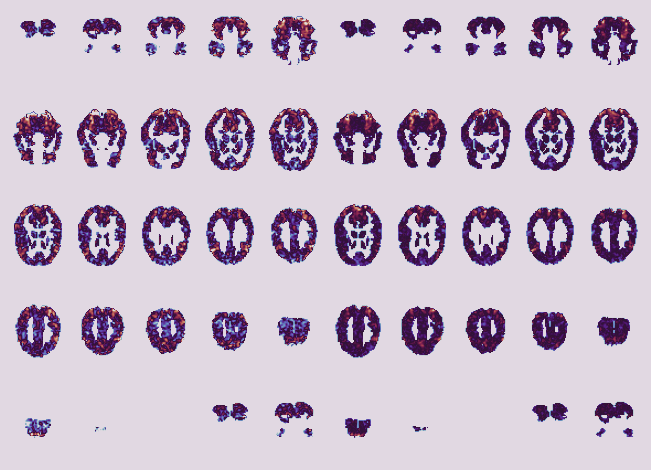

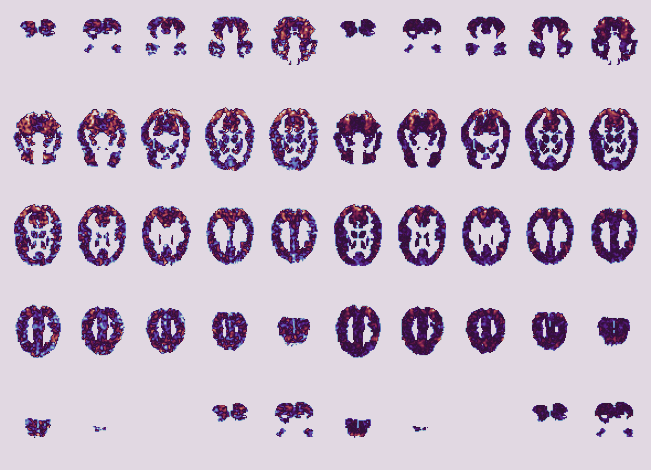

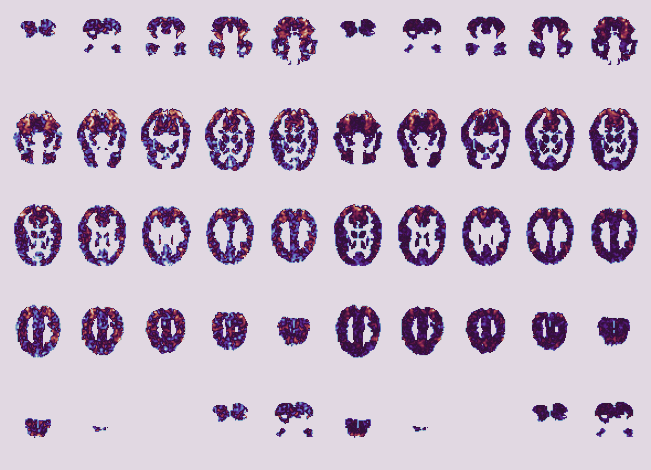

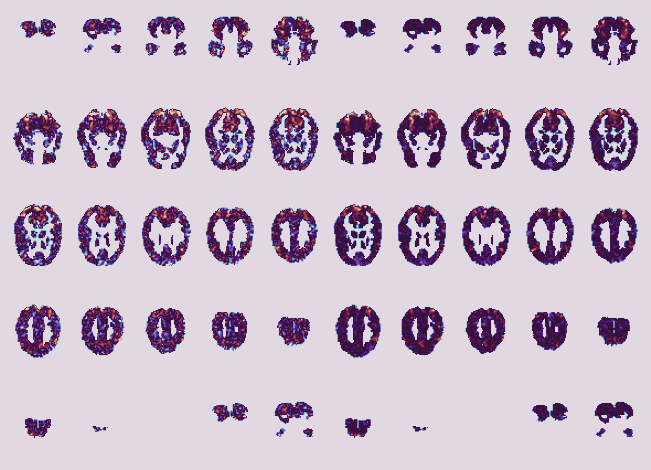

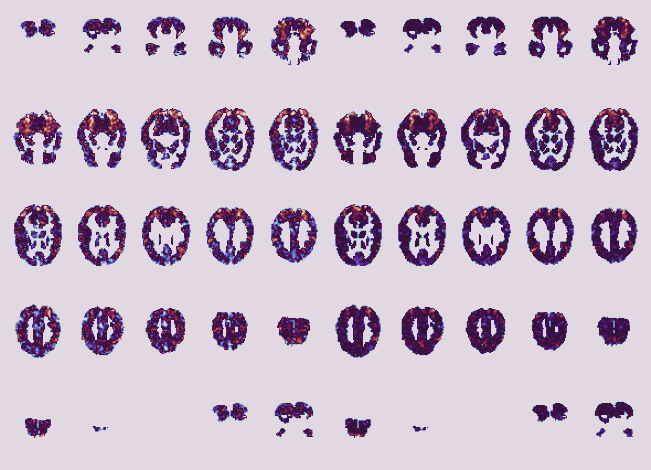

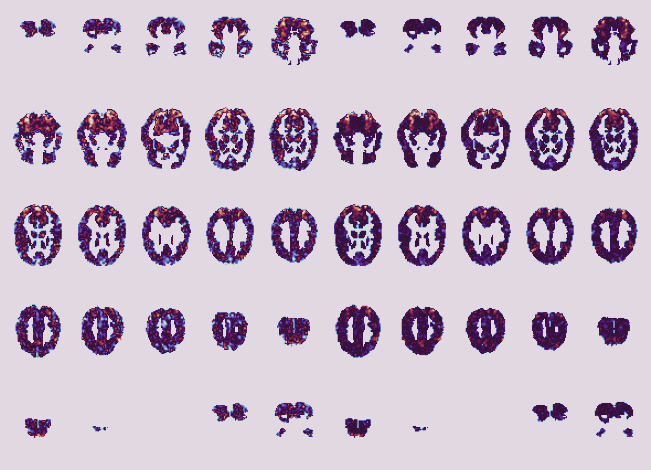

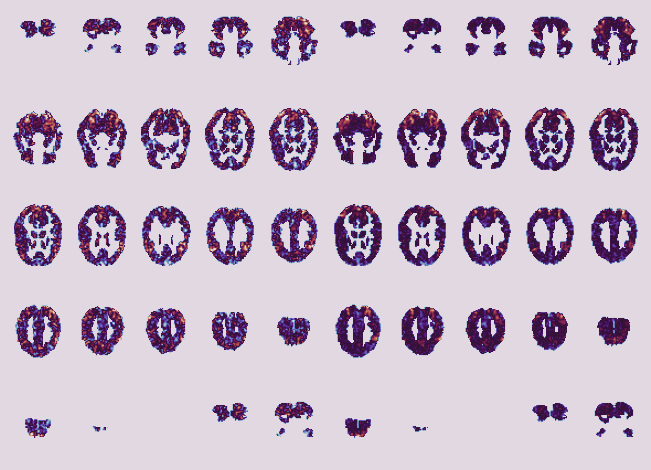

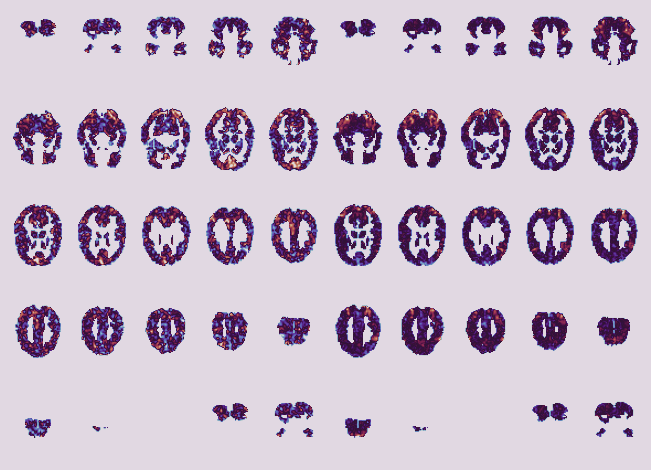

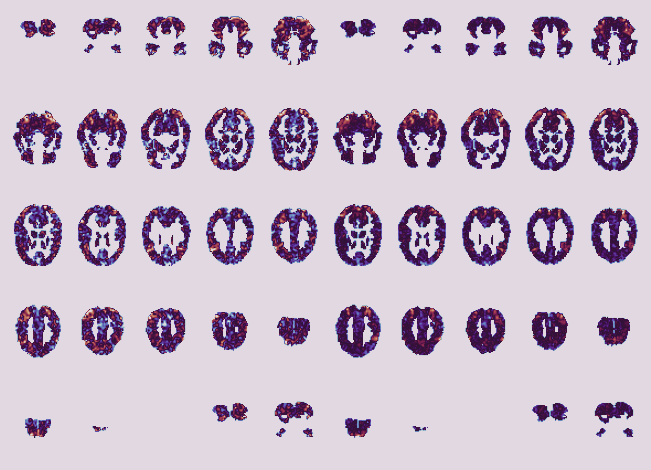

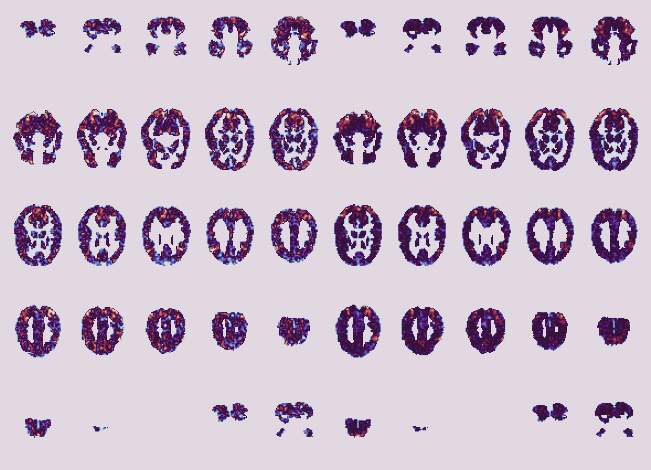

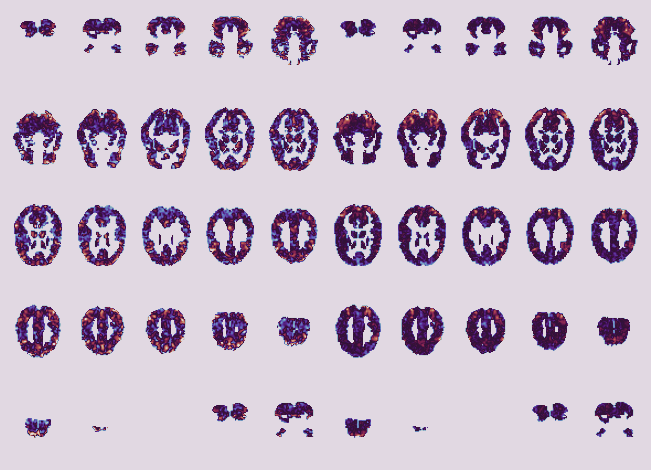

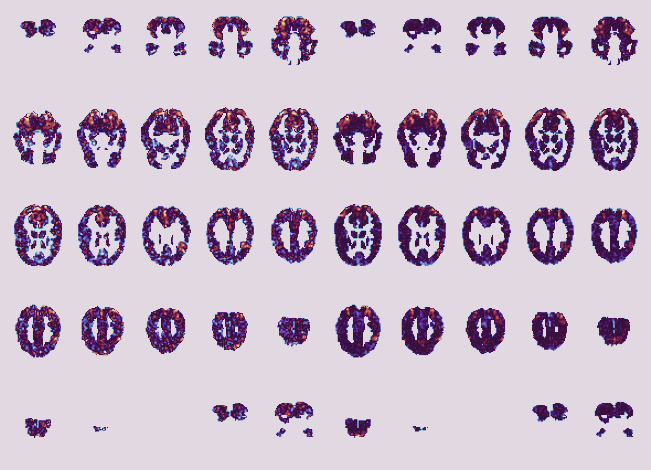

In [8]:
model = BasisSum()

loss = losses.MeanAbsoluteError()
opt = optimizers.Adam(0.01)

for i in range(501):
    if i % 100 == 0:
        pred = model(test_x).numpy()
        print(float(loss(test_y, pred)), end=" ")

    with tf.GradientTape() as tape:
        pred_y = model(train_x)
        batchloss = loss(train_y, pred_y)

        grad = tape.gradient(batchloss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))

        print(i, float(batchloss))

for t, p in zip(test_y, pred):
    double_plot(t, p)